In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from functools import  reduce
from itertools import combinations
from IPython.display import display

In [28]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    s = pd.to_numeric(s, errors='coerce')
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [35]:
def summarize_results(expts_folder, show_figures=True):
    res_folders = [el for el in os.listdir(expts_folder) 
               if os.path.isdir(os.path.join(expts_folder, el))]
    metric = "pcc_median"
    dfs = []
    for res_folder in res_folders:
        template = os.path.join(expts_folder, res_folder) + '/results*'
        fnames = glob(template)
        res_all_hps = []
        for fname in fnames:
            temp = pd.read_csv(fname, delimiter='\t')
            if temp.shape[1] < 2:
                temp = pd.read_csv(fname, delimiter='\t', skiprows=1)
                temp = temp.dropna(how='any', axis=0)
                temp = temp.drop_duplicates(keep=False)
                temp = temp.loc[[temp.pcc_median.argmax()]]                     
            res_all_hps.append(temp)

        if len(res_all_hps) > 0:
            algo_name = '_'.join(res_folder.split('_')[-2:])
            res = pd.concat(res_all_hps, ignore_index=True)
            # res['hps'] = ['_'.join(f.split('/')[-1].split('_')[5:]) for f in fnames]
            res[metric] = pd.to_numeric(res[metric])
            res['size'] = pd.to_numeric(res['size'])
            res = res.loc[res.groupby(["name"])[metric].idxmax()] 
            res.to_csv(os.path.join(expts_folder, 'recap_'+res_folder+'.txt'), 
                       index=False,  float_format='%.3f')
            if show_figures:
                res.plot.scatter('size', metric)
                plt.title(algo_name)
                plt.show()
            dfs.append(res[['name', metric]].set_index('name').rename(
                columns=dict(pcc_median=algo_name)))

    res = pd.concat(dfs, axis=1).apply(pd.to_numeric)
    if show_figures:
        for x, y in combinations(res.columns.tolist(), 2):
            ax = res.plot.scatter(x, y)
            ax.plot((-1, 1), (-1, 1), ls="-", c=".3")
            plt.show()
    else:
        # print(res.to_latex(float_format='%.3f'))
        display(res.style.apply(highlight_max, axis=1).set_precision(3))

,pretrain_cnn,pretrain_lstm,maml_cnn,maml_lstm,krr_lstm,krr_cnn
HLA-DRB1*0101,0.393,0.454,0.417,nan,0.552,0.426
HLA-DRB1*0301,0.329,0.152,0.529,nan,0.452,0.498
HLA-DRB1*0401,0.406,0.0148,0.413,nan,0.516,0.563
HLA-DRB1*0404,0.382,0.104,0.554,nan,0.528,0.595
HLA-DRB1*0405,0.494,-0.0487,0.537,nan,0.591,0.643
HLA-DRB1*0701,0.521,0.27,0.652,nan,0.644,0.679
HLA-DRB1*0802,0.36,0.0804,0.452,nan,0.447,0.427
HLA-DRB1*0901,0.347,0.166,0.448,nan,0.527,0.535
HLA-DRB1*1101,0.531,0.583,0.538,nan,0.674,0.641
HLA-DRB1*1302,0.367,0.0729,0.414,nan,0.419,0.481


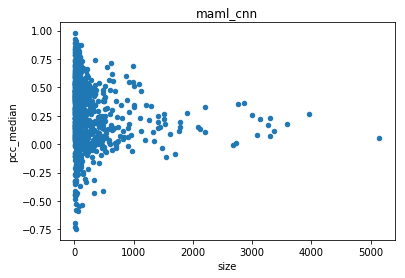

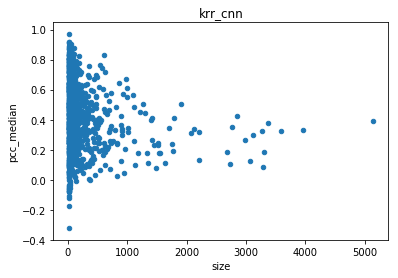

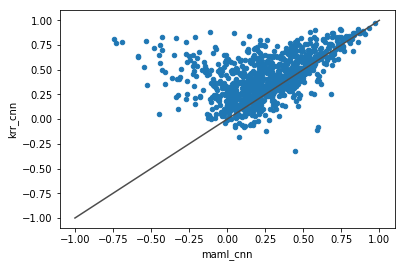

In [36]:
summarize_results(expts_folder='expts_helios_v1', show_figures=False)
summarize_results(expts_folder='expts_helios', show_figures=True)